#### Matching function at the end

### temporary testing for accuracy

In [1]:
#  imports
import os
import numpy as np
import librosa
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('../')


from chromagram import fetch_chromagram
from DTW import dtw_table, dtw, display_dtw_path, similarity_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### generate chromagrams for train files from dataset

In [3]:
# fetch file pairs

sr = 5000
gen_path = "../../dataset3/archive/musicnet/custom_generated_musicnet/"
og_path = "../../dataset3/archive/musicnet/musicnet/train_data/"

# where train files chromagrams will be saved, to be loaded and used during inference
# chroma_path = "../chromagrams/30sec_sr{0}_numpy_files/".format(sr)
chroma_path = "../../chromagrams/full_file_sr{0}_numpy_files/".format(sr)
if not os.path.exists(chroma_path):
    os.mkdir(chroma_path)

file_pairs = []
no_pairs = []
multiple_pairs = []

og_files = os.listdir(og_path)


for file in tqdm(os.listdir(gen_path)):
    file_num = file.split('_')[0]
    topair = [f for f in og_files if file_num in f]
    if len(topair)==0:
        no_pairs.append(file)
        continue
    elif len(topair)>1:
        multiple_pairs.append([file,topair])
        continue
    topair = topair[0]
    file_pairs.append([topair, file])
file_pairs = np.array(file_pairs)

100%|█████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 82255.92it/s]


In [4]:
# save chromagrams

og_files = file_pairs[:,0]
for ogf in tqdm(og_files):
    if os.path.exists(chroma_path+ogf[:-3]+'npy'):
        continue
    # saving 30 seconds chromagrams of all train files with sampling rate 10k
    # change accordingly
#     chromagram = fetch_chromagram(og_path+ogf, sr=sr, end_time=30)
    chromagram = fetch_chromagram(og_path+ogf, sr=sr)
    np.save(chroma_path+ogf[:-3]+'npy', chromagram)

100%|█████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 27721.77it/s]


#### inference (computing closest matches for test files)

In [54]:
def method1(chromagram1, chromagram2):
    # dtw from MIR with cost without normalization
    D = dtw_table(chromagram1.T, chromagram2.T)
    dtw_path = dtw(chromagram1.T, chromagram1.T, D)

    score = similarity_score(D, dtw_path)
    
    return score

def method2(chromagram1, chromagram2):
    # librosa dtw with normalized similarity
#     D, wp = librosa.sequence.dtw(X=chromagram1, Y=chromagram2, subseq=True, metric='euclidean')
    D, wp = librosa.sequence.dtw(X=chromagram1, Y=chromagram2, metric='euclidean')

    s = 0
    min_D = D.min()
    max_D = D.max()

    for i in range(len(wp)):
        x, y = wp[i]
        z = D[x, y]
        s += z

    avg_cost = s / len(wp)
    similarity = abs(1 - ((avg_cost - min_D) / (max_D - min_D)))

    #print(avg_cost)
    #print(similarity)
    
    def display_dtw_path(D, path):
        plt.imshow(D)
        plt.plot(path[:,1],path[:,0], 'r', label='least cost path')
        plt.legend()
        plt.title('Cost Matrix using DTW')
        plt.show()
    
#     display_dtw_path(D, wp)

    return avg_cost

  0%|                                                                                          | 0/320 [00:00<?, ?it/s]

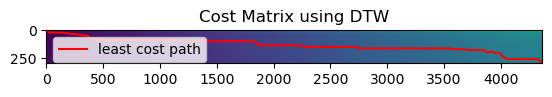

  0%|                                                                                          | 0/320 [00:01<?, ?it/s]


In [24]:
chroma_files = os.listdir(chroma_path)

# each element in final_maps contains [original file, generated midi/test file, closest match file]
final_maps = []
all_scores = []

c=0

for og_file, gen_file in tqdm(file_pairs):
    
    c+=1
    
    # load test file chromagram
    chromagram1 = fetch_chromagram(gen_path+gen_file, sr=sr, end_time=30)
    scores = []
    for chroma_file in chroma_files:
        # fetch each train file chromagram
        chromagram2 = np.load(chroma_path+chroma_file)
        
#         score = method1(chromagram1, chromagram2)
        score = method2(chromagram1, chromagram2)
        
        scores.append(score)
        
        break
    
    chromagram2 = np.load(chroma_path+chroma_files[np.argmin(scores)])
        
    matched_file = chroma_files[np.argmin(scores)]    # argmin in case of cost, argmax in case of similarity
#     matched_file = chroma_files[np.argmax(scores)]    # argmin in case of cost, argmax in case of similarity
    
    # each element in final_maps contains [original file, generated midi/test file, closest match file]
    final_maps.append([og_file, gen_file, matched_file])
    
#     all_scores.append(scores)
    
    
#     if c==10:
    break    # test for one test file print final_maps to check, remove break later

In [18]:
final_maps

[['1727.wav', '1727_schubert_op114_2.wav', '2582.npy'],
 ['1728.wav', '1728_schubert_op114_3.wav', '1728.npy'],
 ['1729.wav', '1729_schubert_op114_4.wav', '2330.npy'],
 ['1730.wav', '1730_schubert_op114_5.wav', '1730.npy'],
 ['1733.wav', '1733_sy_sps92.wav', '2186.npy'],
 ['1734.wav', '1734_sy_sps93.wav', '1734.npy'],
 ['1735.wav', '1735_sy_sps94.wav', '1730.npy'],
 ['1739.wav', '1739_sb99m4.wav', '1739.npy'],
 ['1742.wav', '1742_sb163m2.wav', '2248.npy'],
 ['1749.wav', '1749_sy_sps11.wav', '2346.npy']]

In [7]:
np.save('./all_scores_librosa_sr_{}.npy'.format(sr), all_scores)

##### accuracy

In [10]:
accuracy = 0
for i in final_maps:
    ground_truth = i[0][:-3]
    closest_match = i[2][:-3]
    accuracy += ground_truth==closest_match
accuracy = accuracy/len(final_maps)
accuracy*100

76.875

In [9]:
accuracy

0.76875

In [22]:
final_maps

[['1727.wav', '1727_schubert_op114_2.wav', '1727.npy'],
 ['1728.wav', '1728_schubert_op114_3.wav', '1728.npy'],
 ['1729.wav', '1729_schubert_op114_4.wav', '2482.npy'],
 ['1730.wav', '1730_schubert_op114_5.wav', '1730.npy'],
 ['1733.wav', '1733_sy_sps92.wav', '1733.npy'],
 ['1734.wav', '1734_sy_sps93.wav', '1734.npy'],
 ['1735.wav', '1735_sy_sps94.wav', '1730.npy'],
 ['1739.wav', '1739_sb99m4.wav', '1739.npy'],
 ['1742.wav', '1742_sb163m2.wav', '2523.npy'],
 ['1749.wav', '1749_sy_sps11.wav', '1749.npy'],
 ['1750.wav', '1750_sy_sps12.wav', '1750.npy'],
 ['1751.wav', '1751_sy_sps13.wav', '1751.npy'],
 ['1752.wav', '1752_sy_sps14.wav', '1752.npy'],
 ['1755.wav', '1755_sy_sps52.wav', '2390.npy'],
 ['1756.wav', '1756_sy_sps53.wav', '2463.npy'],
 ['1757.wav', '1757_d958-1.wav', '1807.npy'],
 ['1758.wav', '1758_d958-2.wav', '2167.npy'],
 ['1760.wav', '1760_d958-4.wav', '2576.npy'],
 ['1763.wav', '1763_scbt1421.wav', '2156.npy'],
 ['1764.wav', '1764_scbt1422.wav', '1764.npy'],
 ['1765.wav', '17

In [26]:
np.argmin(all_scores[2])

242

In [31]:
sorted(all_scores[0])

[28.555509326250657,
 31.8876950947138,
 32.35969098499327,
 32.557165722052254,
 32.84283244916622,
 33.41029123297105,
 33.583188535438644,
 33.63853698259308,
 34.035347319583394,
 34.22037788471089,
 34.25268284928414,
 34.62200693806557,
 34.8699067896232,
 34.89590328014814,
 34.900202283783564,
 34.92787119877689,
 35.12421002747521,
 35.13084367202485,
 35.26354754886457,
 35.26992918189083,
 35.42623961152452,
 35.80077062661831,
 35.82009285176173,
 35.94480213610565,
 36.07995762536302,
 36.21277148688017,
 36.40911216395242,
 36.47438472682151,
 36.560503867039316,
 36.586948493315326,
 36.88003616382678,
 36.98850532900542,
 37.036021461710334,
 37.054546031881785,
 37.08244157814589,
 37.59267507819459,
 37.612686946758856,
 37.6507017079924,
 37.69080234661935,
 37.70587195341404,
 37.74768914704892,
 37.820356918162986,
 37.85195607308185,
 37.87261322531544,
 37.92436740375482,
 37.926030366681516,
 38.1045234072389,
 38.26107808706515,
 38.2694463233153,
 38.365249618

Text(0.5, 1.0, 'Sampling Rate vs Accuracy')

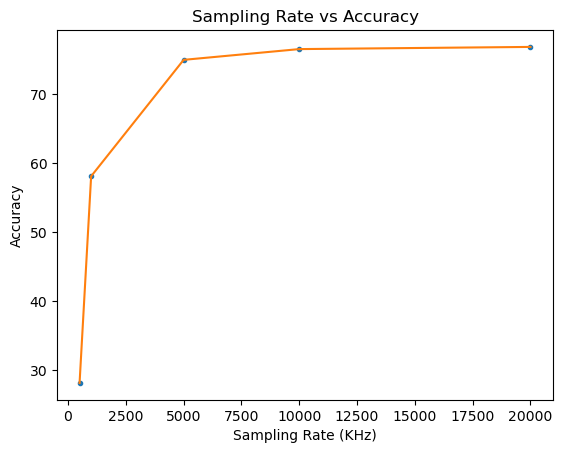

In [11]:
x = [500, 1000, 5000, 10000, 20000]
y = [28.15, 58.12, 75, 76.56, 76.875]
plt.plot(x,y, '.')
plt.plot(x,y)
plt.xlabel("Sampling Rate (KHz)")
plt.ylabel("Accuracy")
plt.title('Sampling Rate vs Accuracy')

Text(0.5, 1.0, 'Sampling Rate vs Accuracy')

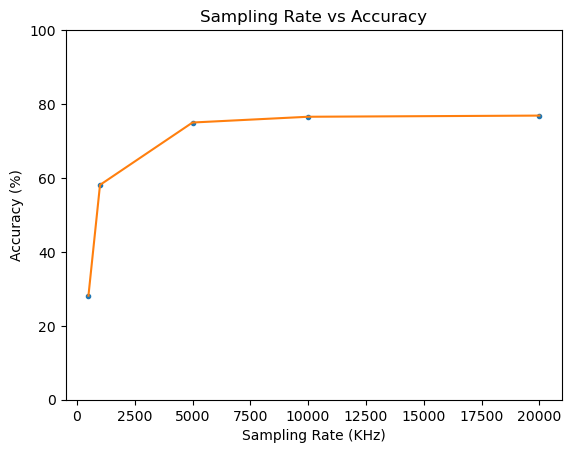

In [25]:
x = [500, 1000, 5000, 10000, 20000]
y = [28.15, 58.12, 75, 76.56, 76.875]
plt.plot(x,y, '.')
plt.plot(x,y)
plt.xlabel("Sampling Rate (KHz)")
plt.ylabel("Accuracy (%)")
plt.ylim(0,100)
plt.title('Sampling Rate vs Accuracy')

Text(0.5, 1.0, 'Sampling Rate vs Time')

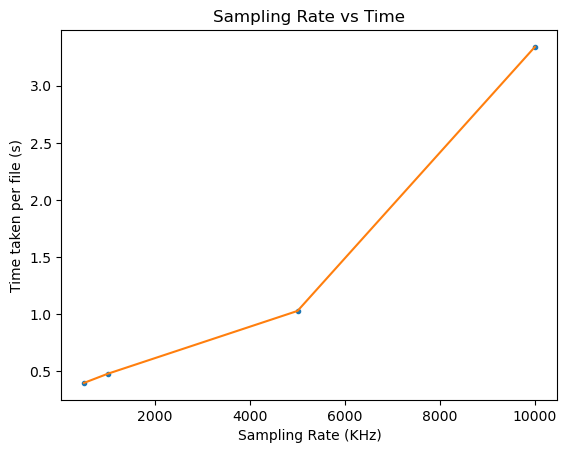

In [38]:
x = [500, 1000, 5000, 10000, 20000, 44100]
y = [0.4, 0.48, 1.03, 3.34, 11.18 52]
plt.plot(x,y, '.')
plt.plot(x,y)
plt.xlabel("Sampling Rate (KHz)")
plt.ylabel("Time taken per file (s)")
plt.title('Sampling Rate vs Time')

Text(0.5, 1.0, 'Accuracy vs Time Tradeoff')

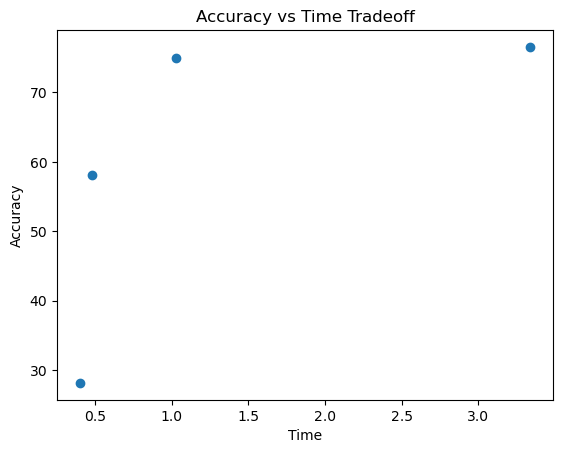

In [39]:
x = [0.4, 0.48, 1.03, 3.34]
y = [28.15, 58.12, 75, 76.56]
plt.scatter(x,y)

plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.title('Accuracy vs Time Tradeoff')

In [55]:
def return_match(test_file_path, database_chroma_path, sr=5000, end_time=30, num_closest_matches=3):
    
    chroma_files = np.array(os.listdir(database_chroma_path))

    chromagram1 = fetch_chromagram(test_file_path, sr=sr, end_time=30)
    scores = []
    for chroma_file in chroma_files:
        # fetch each train file chromagram
        chromagram2 = np.load(database_chroma_path+chroma_file, allow_pickle=True)
        
        score = method2(chromagram1, chromagram2)
        
        scores.append(score)
        
    chromagram2 = np.load(chroma_path+chroma_files[np.argmin(scores)])
        
    sorted_indexes = np.argsort(scores)
    
    sorted_indexes = sorted_indexes[:num_closest_matches]
    
    matched_files = chroma_files[sorted_indexes]
    
    return matched_files

In [56]:
database_chroma_path = "../../chromagrams/30sec_sr5000_numpy_files/"
gen_path = "../../dataset3/archive/musicnet/custom_generated_musicnet/"
test_file_path = gen_path+"1727_schubert_op114_2.wav"


matched = return_match(test_file_path, database_chroma_path)

array(['1727.npy', '1933.npy', '2494.npy'], dtype='<U8')

In [75]:
def match_df(matched):
    df = pd.read_csv(r"D:\files\UCM_acad\SP IOT\project\dataset3\archive\musicnet_metadata.csv.csv")
    df1 = df.query('id=={0}'.format(matched[0][:-4]))
    df2 = df.query('id=={0}'.format(matched[1][:-4]))
    df3 = df.query('id=={0}'.format(matched[2][:-4]))
    df = pd.concat((df1,df2))
    df = pd.concat((df,df3))
    df = df.reset_index()
    df = df.iloc[:,1:]
    return df

In [76]:
import pandas as pd

In [77]:
database_chroma_path = "../../chromagrams/30sec_sr5000_numpy_files/"
gen_path = "../../dataset3/archive/musicnet/custom_generated_musicnet/"
test_file_path = gen_path+"1727_schubert_op114_2.wav"


matched = return_match(test_file_path, database_chroma_path)

df = match_df(matched)
print('3 CLOSEST MATCHES ARE:')
df

3 CLOSEST MATCHES ARE:


,id,composer,composition,movement,ensemble,source,transcriber,catalog_name,seconds
0,1727,Schubert,Piano Quintet in A major,2. Andante,Piano Quintet,European Archive,http://tirolmusic.blogspot.com/,OP114,447
1,1933,Dvorak,String Quartet No 12 in F major,4. Finale: vivace ma non troppo,String Quartet,Museopen,Masahiro Ishii,OP96,351
2,2494,Beethoven,String Quartet No 11 in F minor,1. Allegro con brio,String Quartet,Pascal String Quartet,suzumedia,OP95,297
